# Gold Price Prediction - Modeling Phase

In [ ]:
'''
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡠⠴⠒⠒⠲⠤⠤⣀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠀⠀⠀⠀⠠⢚⣂⡀⠈⠲⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⡀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⡴⠆⠀⠀⠀⠀⠀⢎⠐⢟⡇⠀⠈⢣⣠⠞⠉⠉⠑⢄⠀⠀⣰⠋⡯⠗⣚⣉⣓⡄
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⢠⢞⠉⡆⠀⠀⠀⠀⠀⠓⠋⠀⠀⠀⠀⢿⠀⠀⠀⠀⠈⢧⠀⢹⣠⠕⠘⢧⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠘⠮⠔⠁⠀⠀⠀⠀⢀⠀⠀⠀⠀⠀⠀⠸⡀⠀⠀⠀⠀⠈⣇⠀⢳⠀⠀⠘⡆⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡴⠋⠉⠓⠦⣧⠀⠀⠀⠀⢦⠤⠤⠖⠋⠇⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠸⡄⠈⡇⠀⠀⢹⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠁⠀⠀⠀⠀⠙⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠈⣆⠀⠀⠀⢱⠀⡇⠀⠀⠀⡇⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣼⠀⠀⠀⠀⠀⠀⠘⢆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠸⡄⠀⠀⠀⠳⠃⠀⠀⠀⡇⠀
⠀⠀⠀⠀⠀⢠⢏⠉⢳⡀⠀⠀⢹⠀⠀⠀⠀⢠⠀⠀⠀⠑⠤⣄⣀⡀⠀⠀⠀⠀⠀⣀⡤⠚⠀⠀⠀⠀⠀⢸⢢⡀⠀⠀⠀⠀⠀⢰⠁⠀
⠀⠀⣀⣤⡞⠓⠉⠁⠀⢳⠀⠀⢸⠀⠀⠀⠀⢸⡆⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠁⠀⠀⠀⠀⠀⠀⠀⢸⠀⠙⠦⣤⣀⣀⡤⠃⠀⠀
⠀⣰⠗⠒⣚⠀⢀⡤⠚⠉⢳⠀⠈⡇⠀⠀⠀⢸⡧⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠸⠵⡾⠋⠉⠉⡏⠀⠀⠀⠈⠣⣀⣳⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠹⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⡼⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠳⡄⠀⠀⠀⠀⠀⠀⠀⡰⠁⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠈⠓⠲⠤⠤⠤⠴⠚⠁⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
'''

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
import ace_tools_open as tools;

In [5]:
# Load Data
df = pd.read_csv("../data/filtered_data.csv", index_col="Date", parse_dates=True)
df = df.ffill()
tools.display_dataframe_to_user(name="filtered data", dataframe=df)

filtered data


Loading ITables v2.4.3 from the internet... (need help?)


# Linear Regression - Case 1

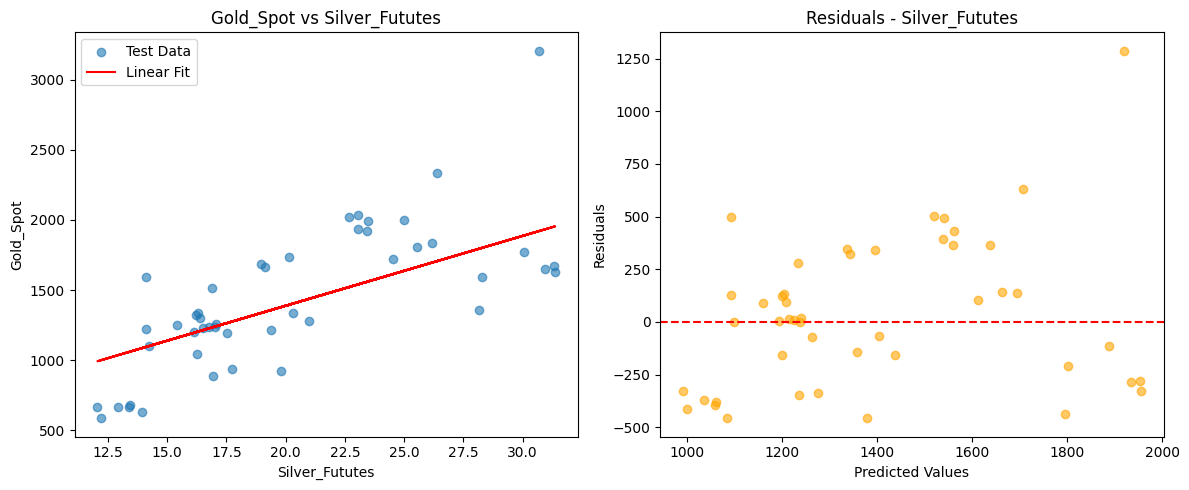

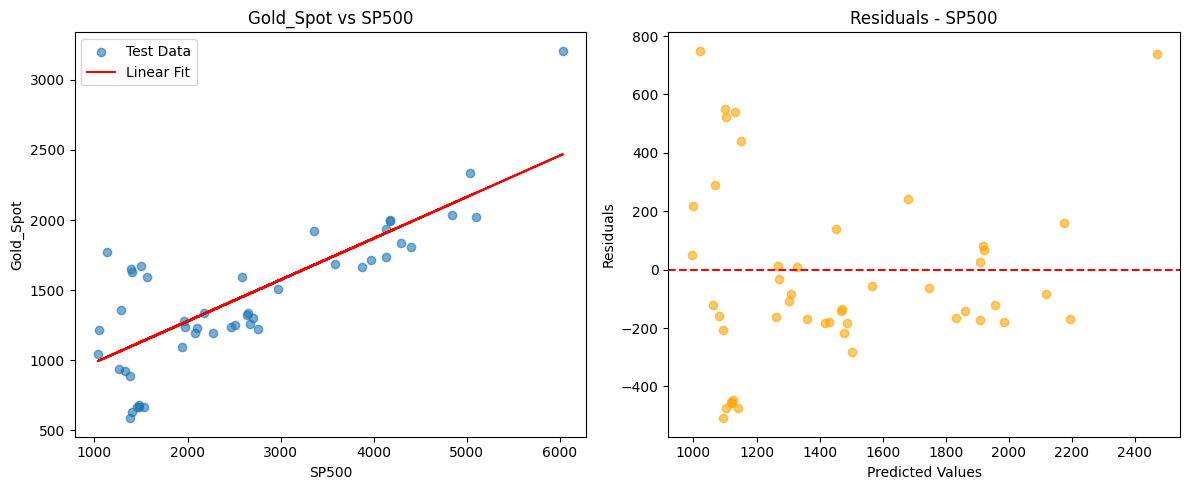

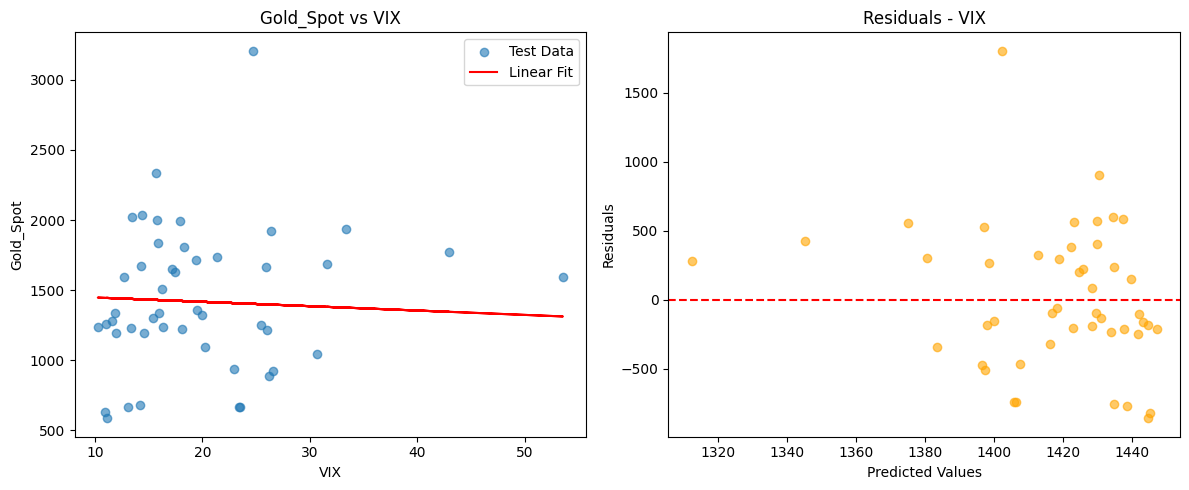

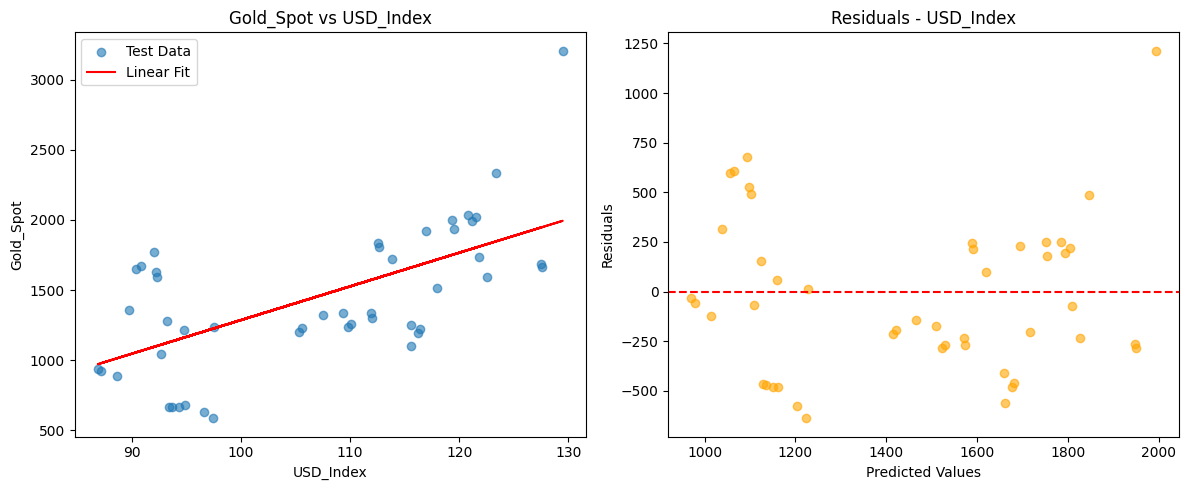

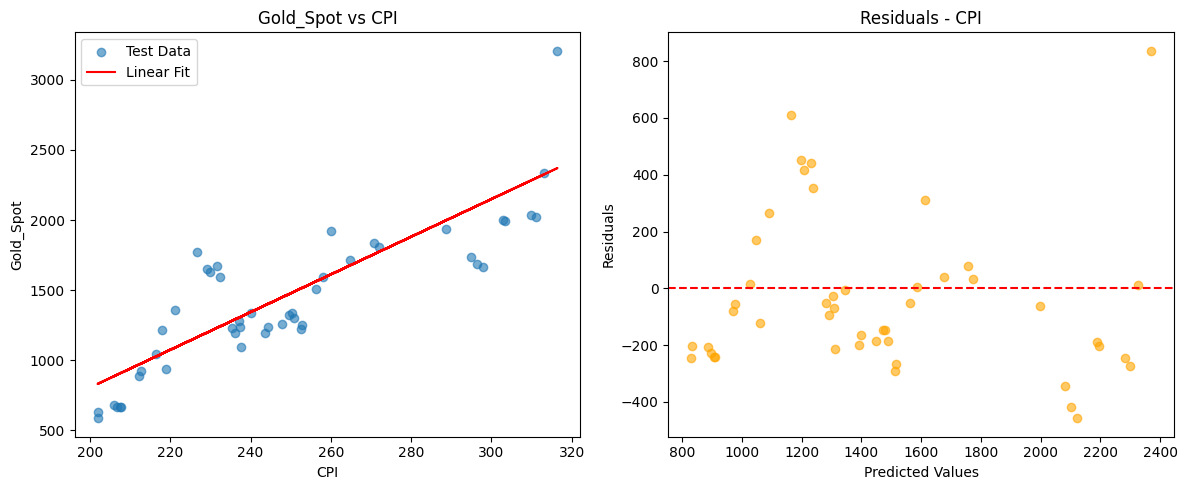

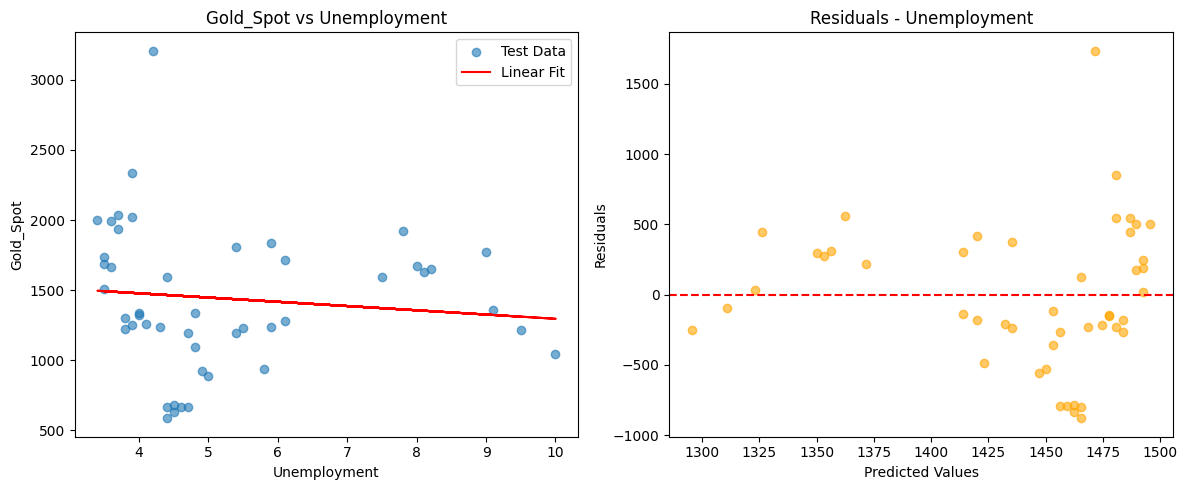

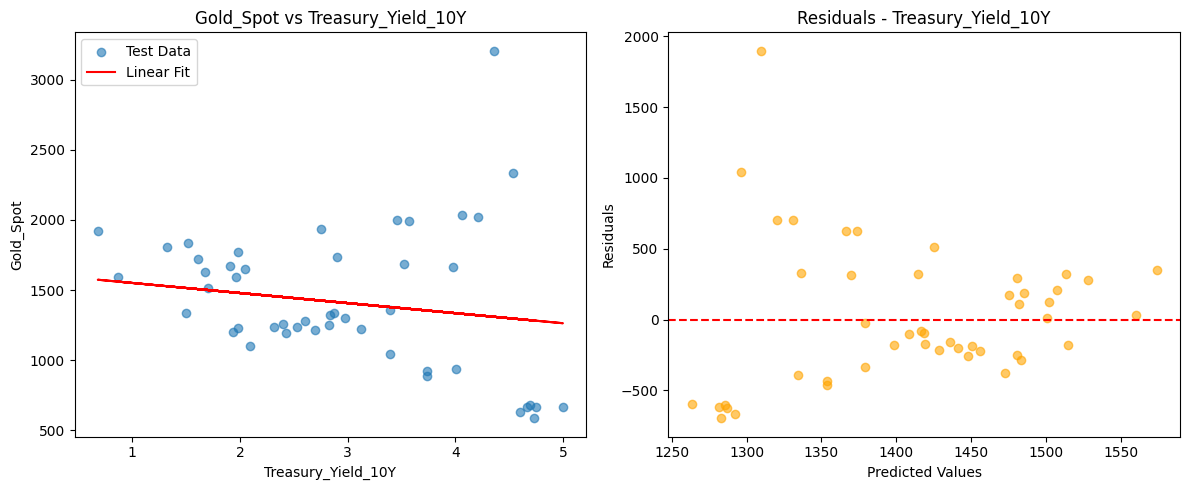

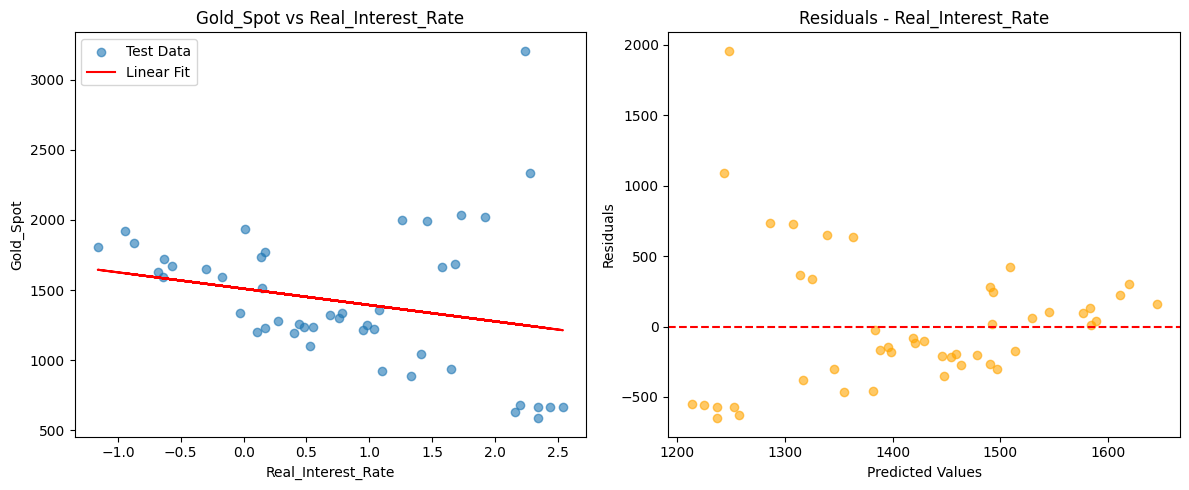

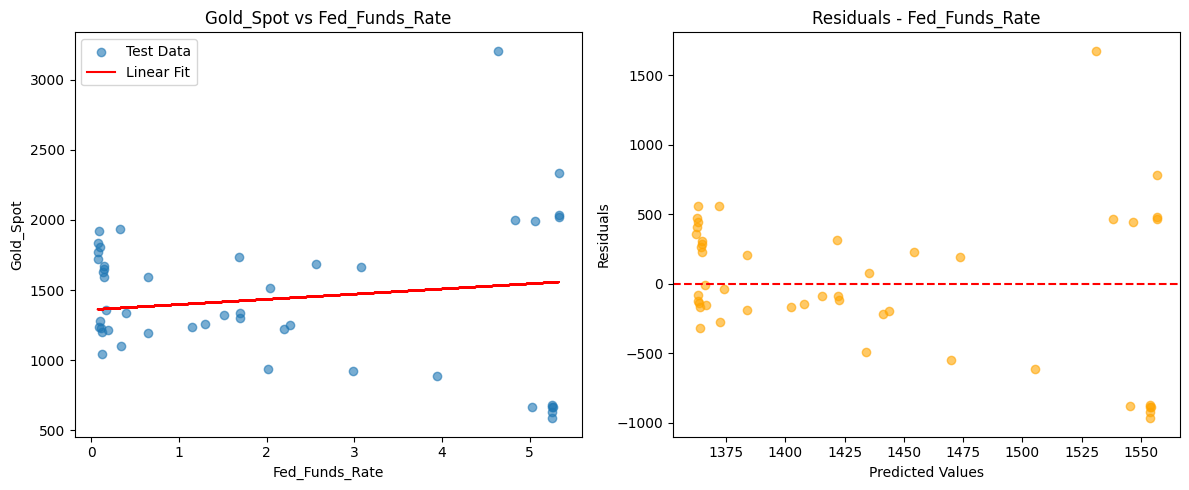

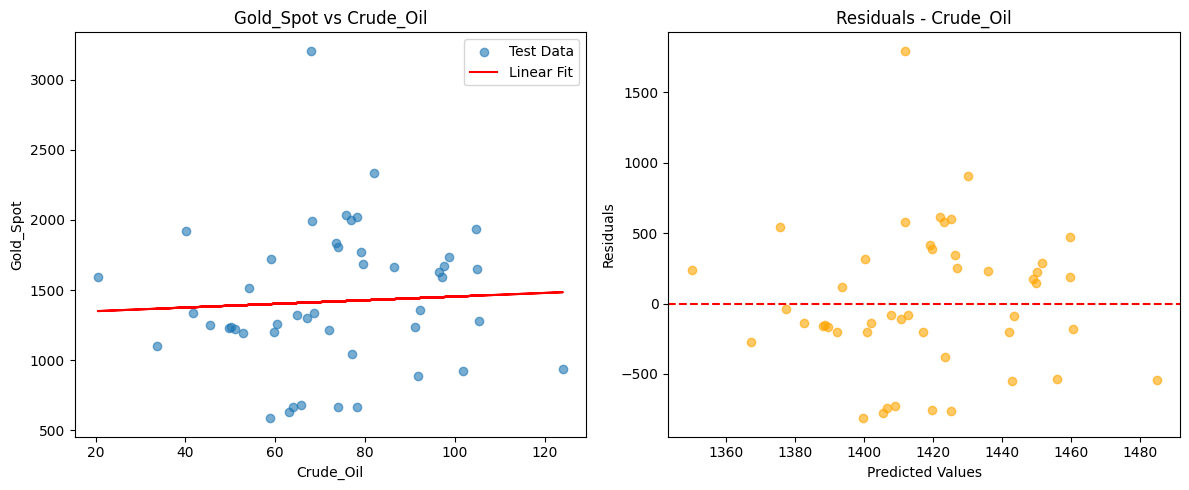

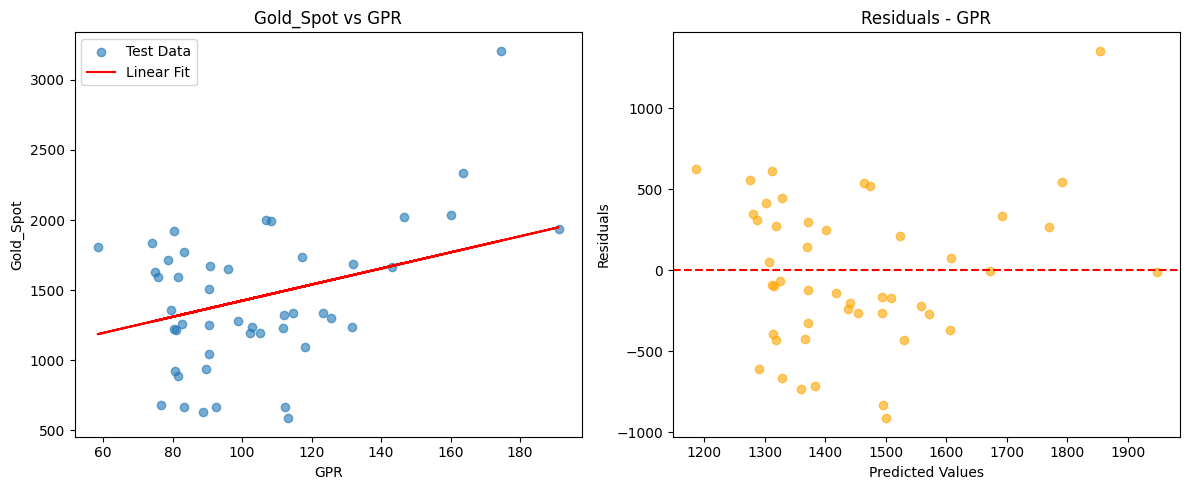

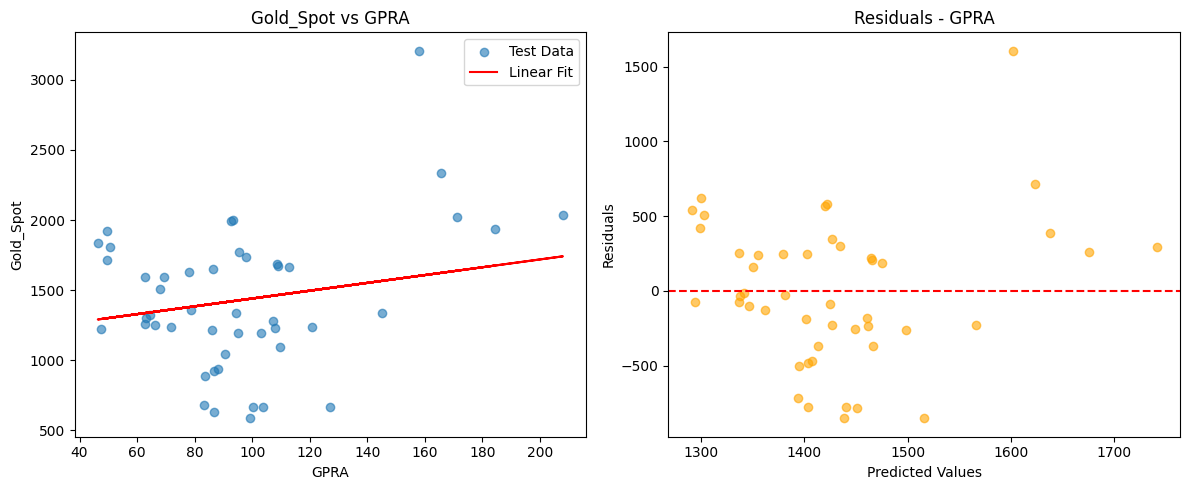


=== Summary of Case 1 (Single Variable Regression) ===


,Feature,Coefficient,Intercept,F-value,p-value,R2,MSE,RMSE,MAE
0,Silver_Fututes,49.85,390.78,238.24,2.069440e-37,0.505,125472.90,354.22,276.31
1,SP500,0.30,687.98,479.90,2.612913e-58,0.637,92078.97,303.45,237.56
2,VIX,-3.11,1478.98,0.01,9.111517e-01,-0.020,258687.23,508.61,403.34
3,USD_Index,24.00,-1113.62,130.66,2.825085e-24,0.395,153565.99,391.87,323.00
4,CPI,13.44,-1882.71,684.60,5.036014e-71,0.712,73079.38,270.33,212.10
5,Unemployment,-30.28,1598.57,3.40,6.646279e-02,-0.002,254164.97,504.15,400.71
6,Treasury_Yield_10Y,-71.84,1622.54,7.42,6.931897e-03,0.052,240426.24,490.33,373.69
7,Real_Interest_Rate,-116.61,1509.72,14.26,2.026854e-04,0.066,236864.34,486.69,356.59
8,Fed_Funds_Rate,36.98,1359.68,2.32,1.294016e-01,-0.044,264977.62,514.76,400.19
9,Crude_Oil,1.30,1323.29,0.84,3.616837e-01,0.005,252384.75,502.38,391.74


In [9]:
# List of features to test (exclude Gold_Spot because it is the target)
df.rename(columns={"S&P_500": "SP500", "^VIX": "VIX"}, inplace=True)
features = df.columns.drop("Gold_Spot")

results = []

for feature in features:
    # print(f"\n=== Testing Feature: {feature} ===")

    # --- Linear Regression (Case 1) ---
    X = df[[feature]]
    y = df["Gold_Spot"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Fit Linear Regression
    lin_reg = LinearRegression()
    lin_reg.fit(X_train, y_train)
    y_pred = lin_reg.predict(X_test)

    coef = round(lin_reg.coef_[0], 2)
    intercept = round(lin_reg.intercept_, 2)

    # --- ANOVA test ---
    model_sm = smf.ols(f'Gold_Spot ~ {feature}', data=df).fit()
    anova_table = sm.stats.anova_lm(model_sm, typ=2)

    f_val = round(anova_table["F"].iloc[0], 2)
    p_val = anova_table["PR(>F)"].iloc[0]

    # R2, MSE, RMSE, MAE
    r2 = round(r2_score(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(root_mean_squared_error(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)

    # Save results to list
    results.append([feature, coef, intercept, f_val, p_val, r2, mse, rmse, mae])

    # Visualize
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12,5))

    # Scatter plot + Linear line
    axes[0].scatter(X_test, y_test, alpha=0.6, label="Test Data")
    axes[0].plot(X_test, y_pred, color='red', label="Linear Fit")
    axes[0].set_title(f"Gold_Spot vs {feature}")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Gold_Spot")
    axes[0].legend()

    # Residual plot 
    axes[1].scatter(y_pred, residuals, alpha=0.6, color="orange")
    axes[1].axhline(0, color='red', linestyle='--')
    axes[1].set_title(f"Residuals - {feature}")
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

# --- Summary table of results ---
summary_df = pd.DataFrame(
    results, columns=["Feature", "Coefficient", "Intercept", "F-value", "p-value", "R2", "MSE", "RMSE", "MAE"]
)

print("\n=== Summary of Case 1 (Single Variable Regression) ===")
display(summary_df)


The results indicate that not all features have a significant linear relationship with Gold_Spot.

Strong predictors: CPI (R² ≈ 0.71), S&P500 (R² ≈ 0.64), and Silver Futures (R² ≈ 0.51) show strong explanatory power with very low p-values, meaning they are statistically significant.

Moderate predictors: USD Index (R² ≈ 0.39) and GPR-related variables (R² ≈ 0.08–0.19) provide some explanatory value but weaker compared to CPI and SP500.

Weak or insignificant predictors: VIX, Crude Oil, Fed Funds Rate, and Unemployment have high p-values (≫ 0.05) and very low or even negative R², indicating they do not contribute meaningfully in a linear setting.

Overall, the best single-feature models are with CPI, SP500, and Silver Futures, which capture a large portion of gold price variation. However, most other variables individually fail to explain gold price movements well, highlighting the need for multivariate and nonlinear models.

In [ ]:
''' ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡞⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⢇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⡠⠊⠀⠈⣇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡌⠀⠀⠀⢧⠀⠀⠀⠀⠀⠀⠀⡜⠁⠀⠀⠀⠀⠣⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡪⠄⠀⠀⠀⠀⡇⣀⣀⣀⡤⠤⡧⠥⠀⠀⠀⠀⠀⠀⢳⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣠⠃⠀⠀⠀⠀⠀⠳⠀⠀⠀⠀⠀⠀⠀⠀⠀⣀⡤⡀⠀⠈⡇⠀⠀⢀⡠⠔⠂⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⣀⣀⠀⡇⠀⠀⠀⠀⡤⠂⡀⠀⠀⠀⠀⠀⠀⠀⢀⡜⠁⠀⡇⠀⠀⣧⠂⠃⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠁⢺⠢⢀⡀⠀⡇⠀⠉⠢⡀⠀⡏⠉⡇⠀⣇⡀⠀⢀⡇⠀⠎⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⡇⠀⠀⠁⠙⣆⣀⡠⠞⠀⡏⣑⡇⠀⠀⠉⠉⠁⠀⡄⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠠⠐⢯⡈⠁⠁⠀⠀⠀⠀⠀⡗⠀⠀⢧⠀⠀⠀⠀⠀⠀⠈⡳⠥⣀⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠐⠊⠈⠀⠀⠀⠀⠙⢄⡀⠀⠀⠀⠀⡎⠀⠀⠀⠀⡇⠀⠀⠀⠀⣠⠎⠁⠀⠀⠀⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠣⢄⣀⠀⠀⠀⠀⠀⠀⠀⣀⣀⡤⠞⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠉⠉⠉⠉⠉⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
'''

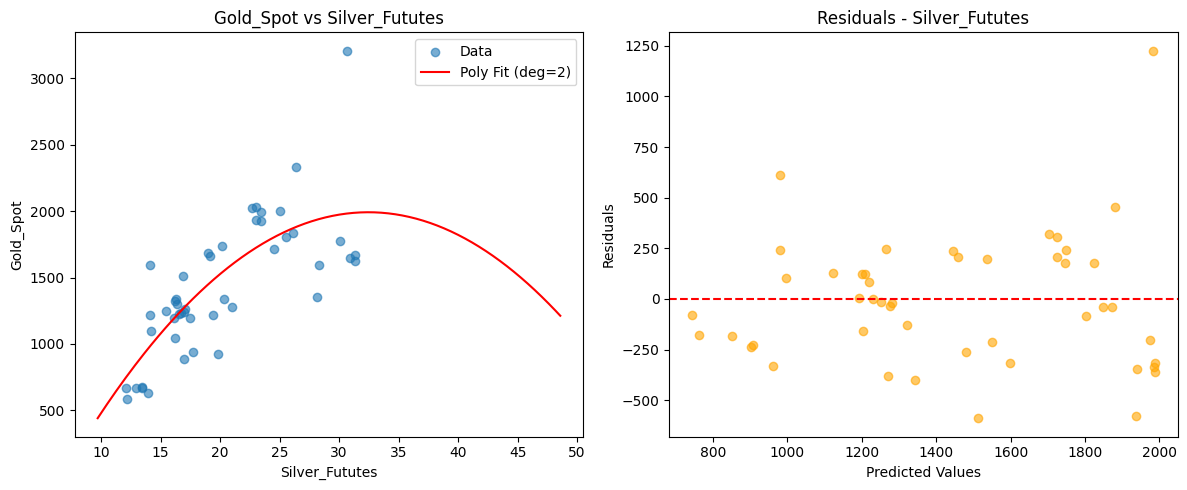

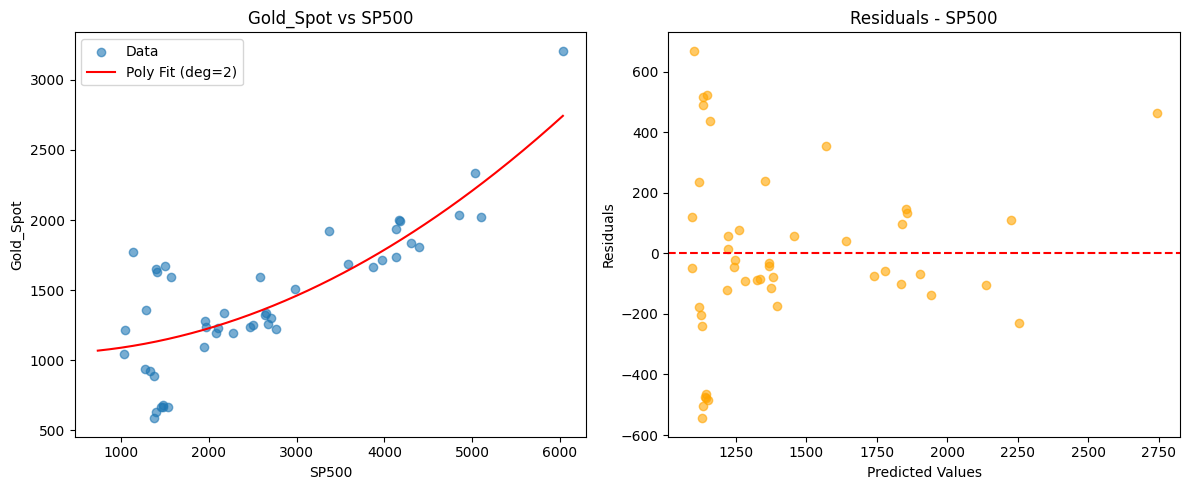

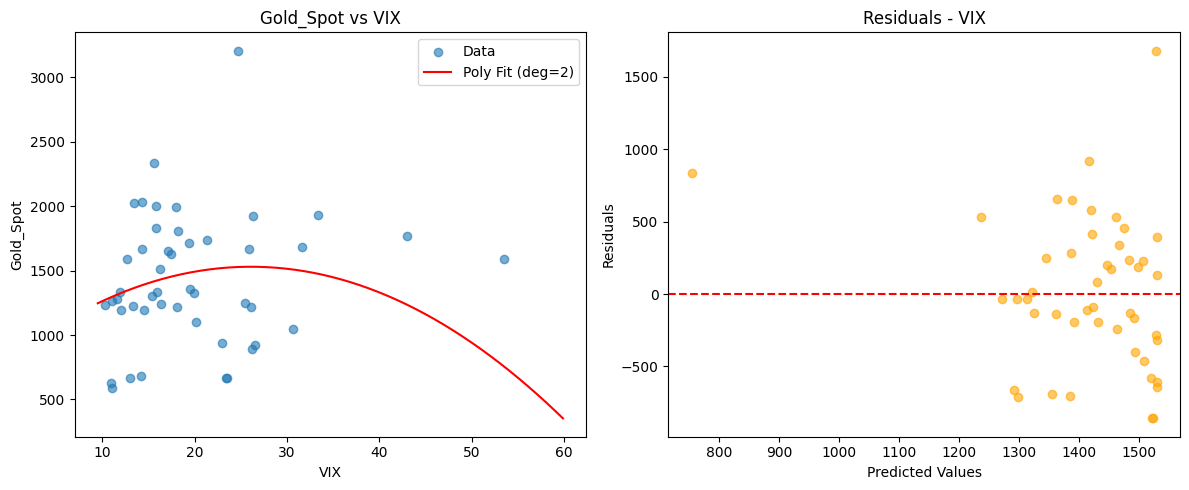

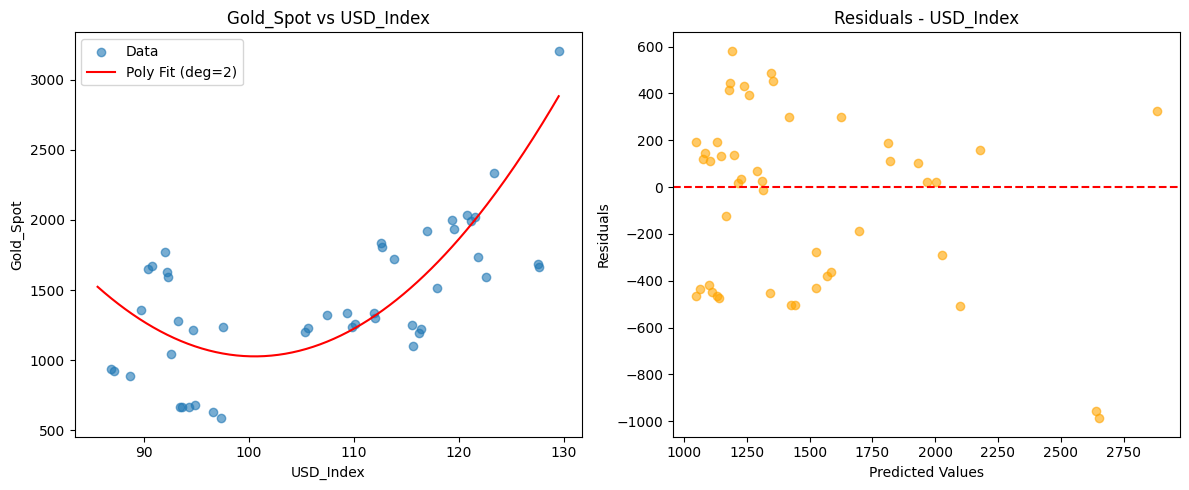

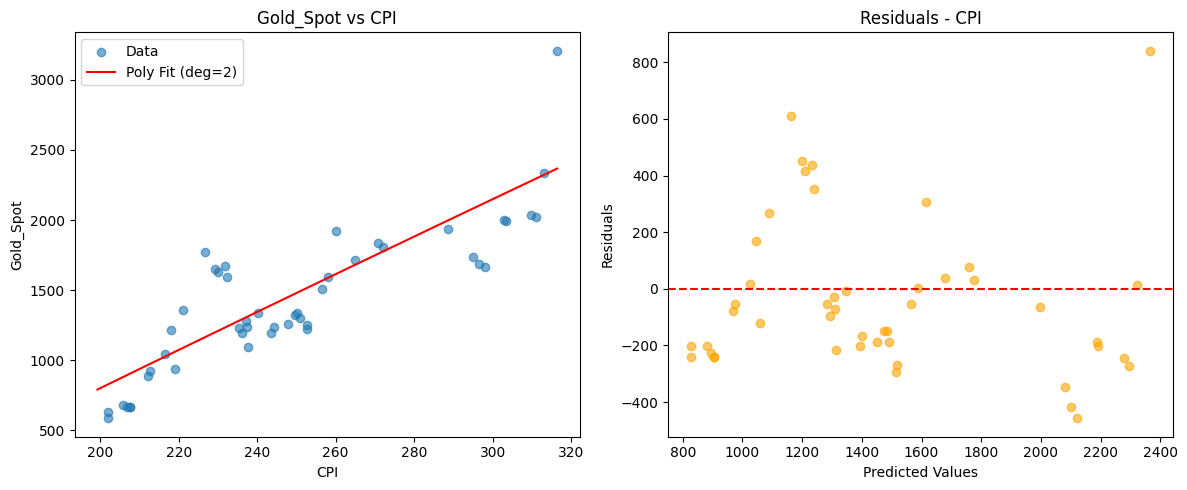

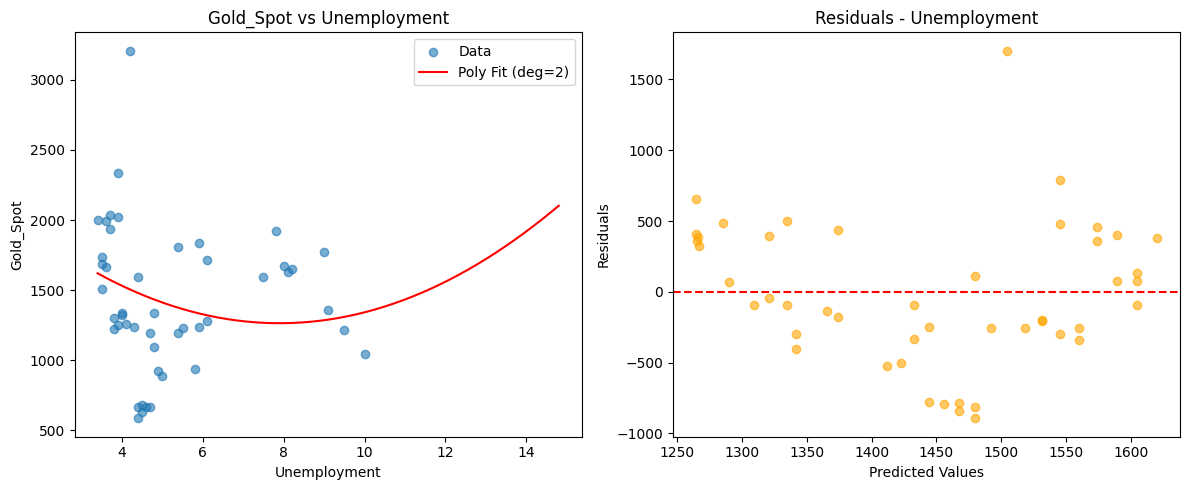

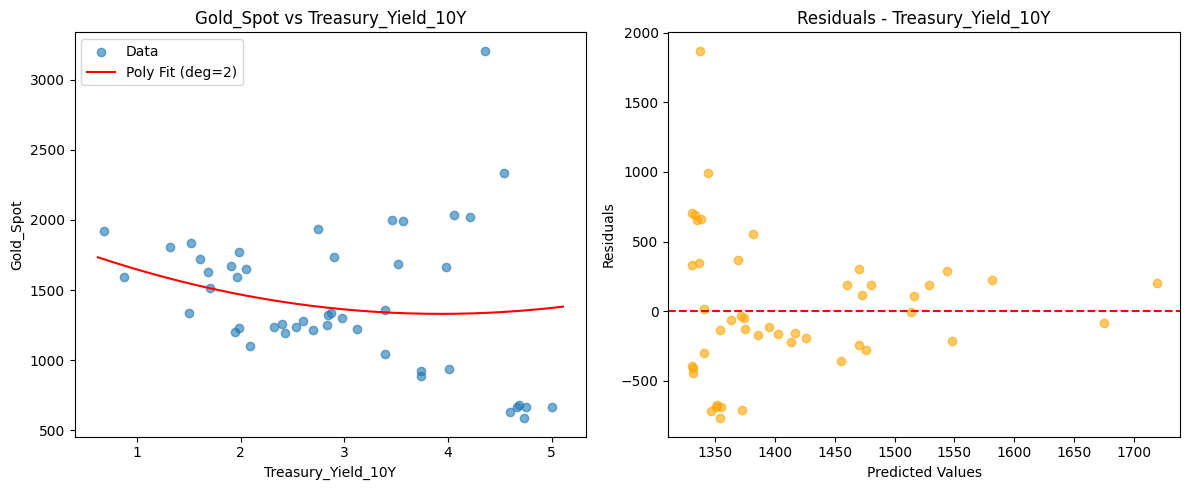

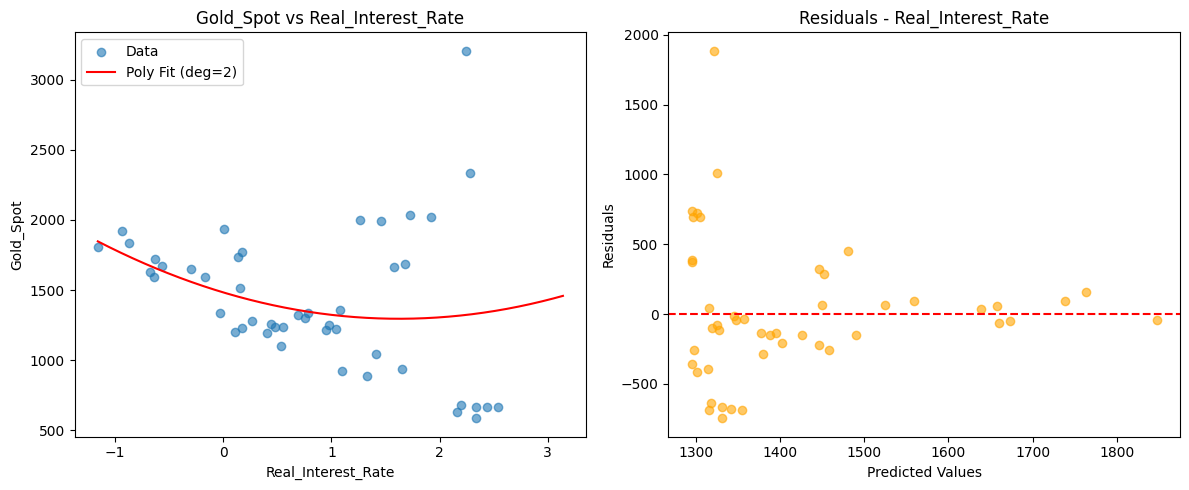

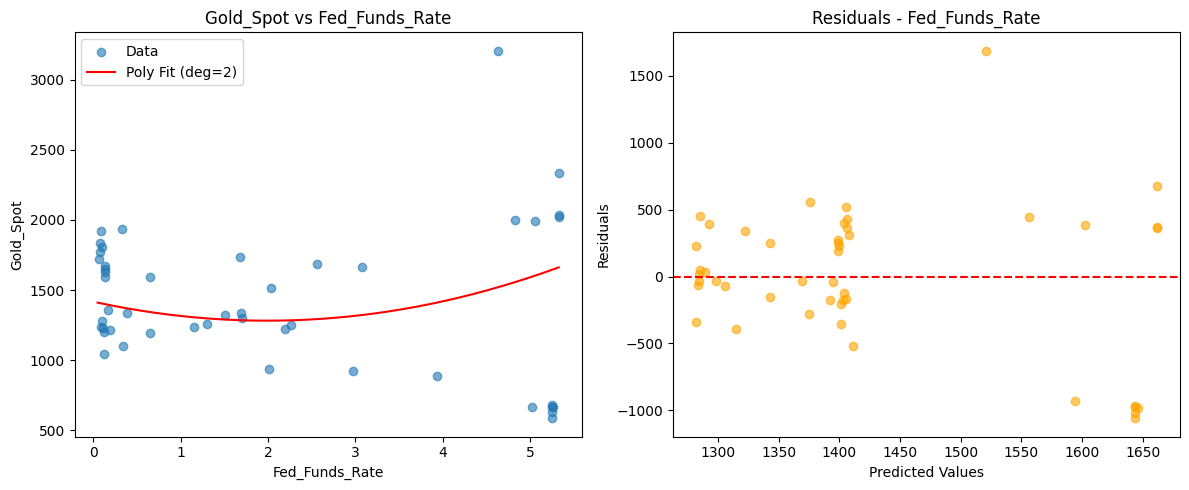

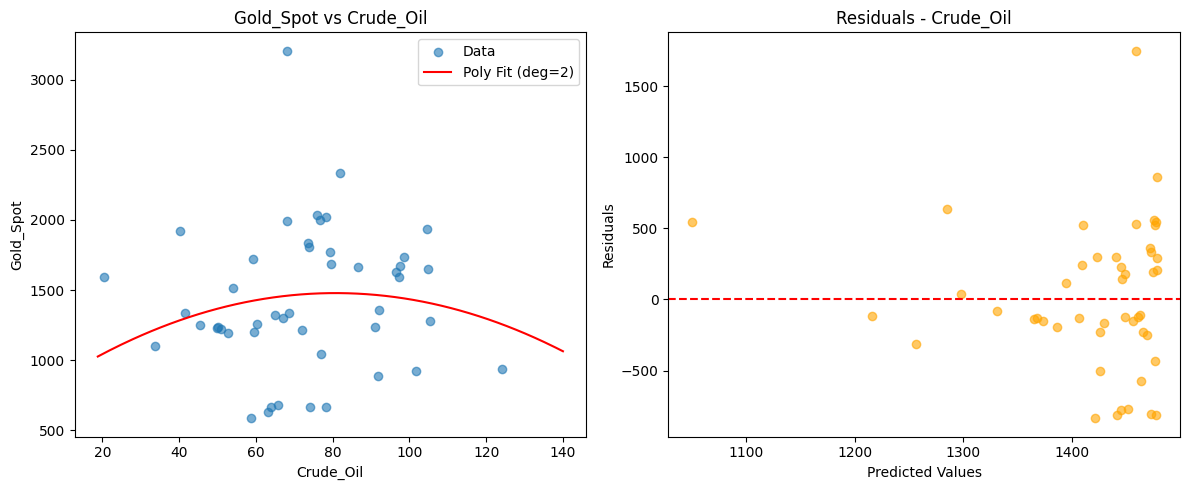

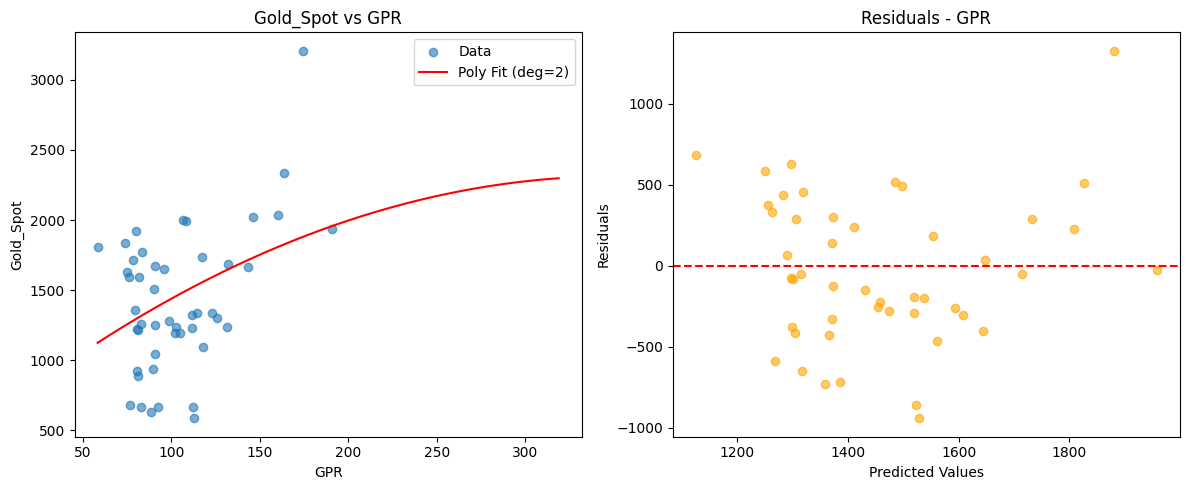

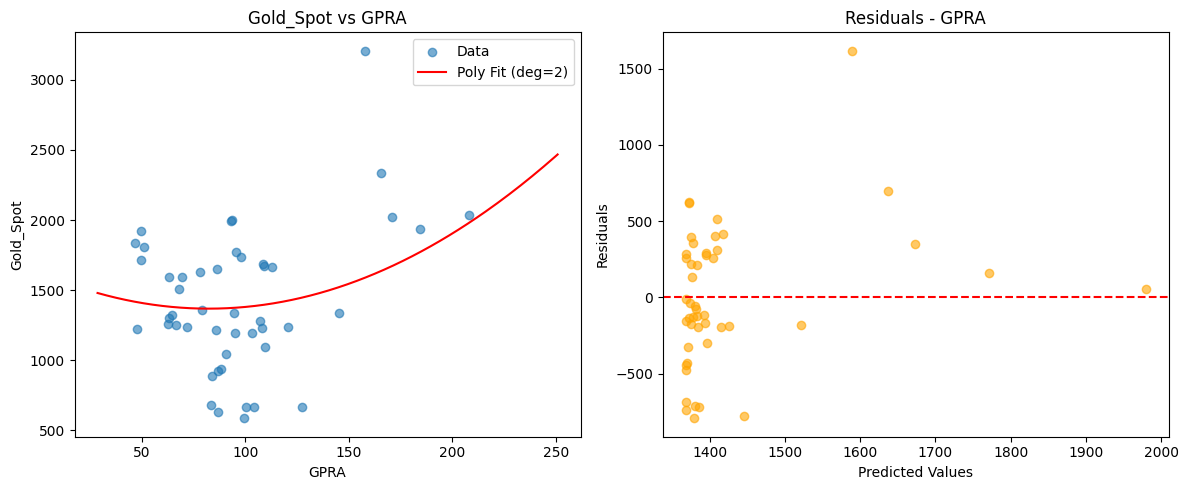


=== Summary of Polynomial Regression (degree=2, Single Variable) ===


,Feature,Coefficients,Intercept,F-value,p-value,R2,MSE,RMSE,MAE
0,Silver_Fututes,"[194.641, -2.998]",-1167.756,174.20,5.507296e-30,0.596,102544.45,320.23,244.42
1,SP500,"[-0.003, 0.0]",1045.294,0.11,7.378387e-01,0.685,79965.01,282.78,214.63
2,VIX,"[53.778, -1.03]",828.608,9.86,1.908456e-03,-0.044,264822.73,514.61,405.22
3,USD_Index,"[-446.098, 2.218]",23456.745,130.21,3.412694e-24,0.432,144141.16,379.66,310.34
4,CPI,"[14.415, -0.002]",-2006.654,3.99,4.705953e-02,0.712,73006.90,270.20,211.91
5,Unemployment,"[-277.848, 17.588]",2361.518,11.44,8.466628e-04,0.011,250920.97,500.92,398.83
6,Treasury_Yield_10Y,"[-289.706, 36.862]",1899.361,2.32,1.290576e-01,0.033,245409.62,495.39,369.85
7,Real_Interest_Rate,"[-231.343, 71.174]",1483.238,15.88,9.057108e-05,0.073,235194.94,484.97,338.73
8,Fed_Funds_Rate,"[-136.046, 34.141]",1417.070,2.35,1.270451e-01,-0.063,269796.95,519.42,389.50
9,Crude_Oil,"[19.075, -0.118]",708.367,3.94,4.825371e-02,0.008,251781.99,501.78,390.85


In [9]:
# Polynomial Regression
df.rename(columns={"S&P_500": "SP500", "^VIX": "VIX"}, inplace=True)
features = df.columns.drop("Gold_Spot")

results_poly = []

for feature in features:
    X = df[[feature]]
    y = df["Gold_Spot"]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Polynomial transform (degree=2)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Fit model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    coefs = [round(c, 3) for c in model.coef_]
    intercept = round(model.intercept_, 3)

    # ANOVA test
    formula = f"Gold_Spot ~ {feature} + I({feature}**2)"
    model_sm = smf.ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model_sm, typ=2)

    f_val = round(anova_table["F"].iloc[0], 2)
    p_val = anova_table["PR(>F)"].iloc[0]

    # Metris
    r2 = round(r2_score(y_test, y_pred), 3)
    mse = round(mean_squared_error(y_test, y_pred), 2)
    rmse = round(root_mean_squared_error(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)

    results_poly.append([feature, coefs, intercept, f_val, p_val, r2, mse, rmse, mae])

    # Visualization
    residuals = y_test - y_pred

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter + Poly Fit
    X_sorted = pd.DataFrame(
        np.linspace(X[feature].min(), X[feature].max(), 200), 
        columns=[feature]
    )
    X_sorted_poly = poly.transform(X_sorted)
    
    y_sorted_pred = model.predict(X_sorted_poly)

    axes[0].scatter(X_test, y_test, alpha=0.6, label="Data")
    axes[0].plot(X_sorted, y_sorted_pred, color="red", label="Poly Fit (deg=2)")
    axes[0].set_title(f"Gold_Spot vs {feature}")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Gold_Spot")
    axes[0].legend()

    # Residual plot
    axes[1].scatter(y_pred, residuals, alpha=0.6, color="orange")
    axes[1].axhline(0, color="red", linestyle="--")
    axes[1].set_title(f"Residuals - {feature}")
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Residuals")

    plt.tight_layout()
    plt.show()

# --- Summary table ---
summary_poly = pd.DataFrame(
    results_poly,
    columns=["Feature", "Coefficients", "Intercept", "F-value", "p-value", "R2", "MSE", "RMSE", "MAE"]
)

print("\n=== Summary of Polynomial Regression (degree=2, Single Variable) ===")
display(summary_poly)

The polynomial models show mixed performance across features.

Best predictors: CPI (R² ≈ 0.71), SP500 (R² ≈ 0.68), and Silver Futures (R² ≈ 0.60) remain the strongest variables, similar to linear regression, with improved fit in some cases.

Moderate predictors: USD Index (R² ≈ 0.43) and GPR-related indices (R² ≈ 0.17–0.18) capture partial variations but are less reliable.

Weak/insignificant predictors: VIX, Crude Oil, Fed Funds Rate, and Unemployment show very low or even negative R² values, meaning polynomial transformation does not improve their predictive power.

Overall, polynomial regression slightly enhances performance for Silver Futures but does not drastically outperform linear models. Strong explanatory features remain consistent, suggesting that multivariate approaches are more promising.